## Simple demonstration of ExtendedKalmanFilter with Constant Velocity Model

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from bayesfilt.filters import ExtendedKalmanFilter
from bayesfilt.models import ConstantVelocity, LinearObservationModel

In [4]:
# generate observations
np.random.seed(30)
dt_true = 0.1
nsamples = 100
tlist = np.linspace(0,nsamples*dt_true, nsamples)
y_true = np.sin(1.*tlist) 
ylist = y_true + 0.1*np.random.randn(nsamples)

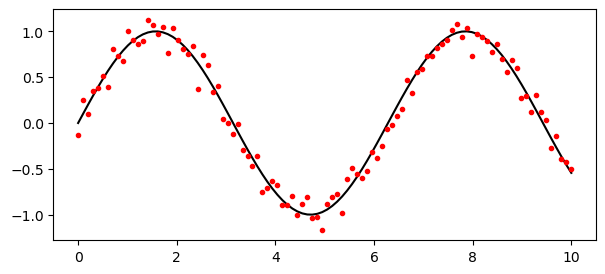

In [5]:
fig, ax = plt.subplots(figsize=(7,3))
ax.plot(tlist, y_true, '-k')
ax.plot(tlist, ylist, '.r')

In [6]:
# dynamics model
mm = ConstantVelocity(dof=1, sigma_speed=0.2)
mm

ConstantVelocity(name='ConstantVelocity1D', nx=2, xnames=['Position0', 'Speed0'])

In [7]:
# observation model
om = LinearObservationModel(nx=2, obs_state_inds=[0], xnames=mm.xnames)
om

LinearObservationModel(name='LinearObsModel(2/1)', nx=2, xnames=['Position0', 'Speed0'])

In [8]:
# kalman filter
dt=0.05
kf = ExtendedKalmanFilter(
    nx=mm.nx,
    ny=om.ny,
    dt=dt,
    fun_f = lambda x: mm.func_Fmat(dt=dt) @ x,
    fun_Fjac=lambda x: mm.func_Fmat(dt=dt),
    fun_Q=lambda x: mm.func_Qmat(dt=dt),
    fun_h = lambda x: om.Hmat @ x,
    fun_Hjac=lambda x: om.Hmat,
    xnames=mm.xnames
)
print(kf)

ExtendedKalmanFilter: Setting dt_tol to 0.025
ExtendedKalmanFilter(nx=2, ny=1, dt=0.05, dt_tol=0.025, epsilon=1e-06, verbose=False, object_id=0)


In [9]:
# initiate and run
kf.initiate(
    t0=tlist[0],
    m0=[ylist[0],0],
    P0=np.diag([0.1, 0.1]),
    flag='Update'
)
kf.filter(
    list_of_t=tlist[1:],
    list_of_y=ylist[1:],
    list_of_R = np.diag([0.1**2])
)
kf.smoother()

ExtendedKalmanFilter(S): 100%|██████████| 300/300 [00:00<00:00, 585.99it/s]


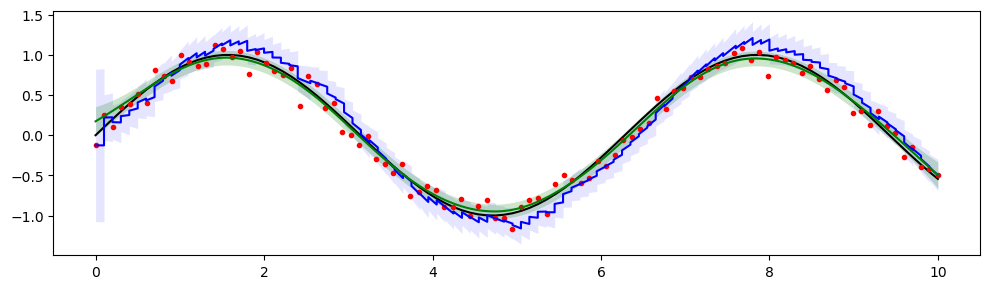

In [10]:
fig, ax = plt.subplots(figsize=(10,3))
ax.plot(tlist, y_true, '-k')
ax.plot(tlist, ylist, '.r')
# filter
ax.plot(kf.logger.time_elapsed, kf.logger.state_mean_i(0), '-b')
ax.fill_between(
    kf.logger.time_elapsed, 
    kf.logger.state_mean_i(0) - 3*np.sqrt(kf.logger.state_var_ij(0)), 
    kf.logger.state_mean_i(0) + 3*np.sqrt(kf.logger.state_var_ij(0)),
    color='b', alpha=0.1, lw=0
)
# smoother
ax.plot(kf.slogger.time_elapsed, kf.slogger.state_mean_i(0), '-g')
ax.fill_between(
    kf.slogger.time_elapsed, 
    kf.slogger.state_mean_i(0) - 3*np.sqrt(kf.slogger.state_var_ij(0)), 
    kf.slogger.state_mean_i(0) + 3*np.sqrt(kf.slogger.state_var_ij(0)),
    color='g', alpha=0.2, lw=0
)
fig.tight_layout()

In [11]:
kf.df.head()

,TimeElapsed,Flag,Position0,Position0_Var,Speed0,Speed0_Var,XresNorm,YresNorm,NIS,NEES,LogLik
0,0.00,Update,-0.126405,0.100000,0.000000,0.100000,NaN,NaN,NaN,NaN,NaN
1,0.05,Forecast,-0.126405,0.100253,0.000000,0.102001,NaN,NaN,NaN,NaN,NaN
3,0.10,Update,0.219396,0.009100,0.034917,0.103066,0.347560,0.380034,1.300955,13.140201,-0.470373
4,0.15,Forecast,0.221142,0.009452,0.034917,0.105067,NaN,NaN,NaN,NaN,NaN
6,0.20,Update,0.162265,0.005082,-0.032135,0.100648,0.090395,0.119310,0.700196,0.723158,0.678793


In [12]:
kf.dfs.head()

,TimeElapsed,Flag,Position0,Position0_Var,Speed0,Speed0_Var,XresNorm,YresNorm,NIS,NEES,LogLik
0,0.00,Update,0.172923,0.003698,0.619183,0.019442,NaN,NaN,NaN,NaN,NaN
1,0.05,Forecast,0.204190,0.003154,0.631417,0.018192,NaN,NaN,NaN,NaN,NaN
2,0.10,Update,0.236060,0.002691,0.643352,0.016890,0.010171,0.017569,0.015868,0.062202,1.043045
3,0.15,Forecast,0.268521,0.002303,0.655075,0.015578,NaN,NaN,NaN,NaN,NaN
4,0.20,Update,0.301566,0.001984,0.666674,0.014301,0.152185,0.197988,2.465755,8.379618,-0.081017
